<a href="https://colab.research.google.com/github/lblogan14/PyTorch_tutorial_colab/blob/main/7_Model_Understanding_with_Captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Camtum is an open source, extensible librayr for model interpretability built on PyTorch.
[captum.ai](https://captum.ai/)

#Installation

In [1]:
%pip install torch torchvision captum

#A First Example
We start with a ResNet model pretrained on the ImageNet dataset. We will get a test input, and use different Feature Attribution algorithms to examine how the input images affect he output, and see a helpful visualization of this input attribution map for some test images

Import:

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Now, download a pretrained ResNet. Since we are not training, we will place it in evaluation mode for now:

In [3]:
model = models.resnet101(pretrained=True)
model = model.eval()

If we save a cat picture within the same working folder,

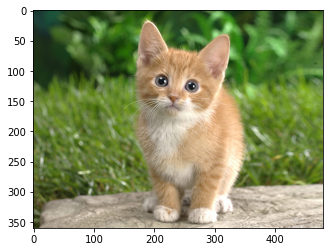

In [4]:
test_img = Image.open('./img/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

The ResNet model was trained on the ImageNet dataset, and expects images to be of a certain size, with the channel data normalized to a specific range of values.

In [5]:
# model expects 224x224 3-color image
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.CenterCrop(224),
     transforms.ToTensor()]
)

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

We need the readable labels pre-loaded as well:

In [6]:
labels_path = './img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

What does the model think this image represents?

In [7]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label= idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tabby ( 0.4236903488636017 )


#Feature Attribution with Integrated Gradients
**Feature attribution** attributes a particular output to features of the input. It uses a specific input - the test image - to generate a map of the relative importance of each input feature to a particular output feature.

**Integrated Gradients** assigns an importance score to each input feature by approximating the integral of the gradients of the model's output with respect to the inputs.

In our case, we take a specific element of the output vector - that is, the one indicating the model's confidence in its chosen category - and use Integrated Gradients to understand what parts of the input image contributed to this output.

Once we have the importance map from Integrated Gradients, we will use the visualization tools in Captum to give a helpful representation of the importance map. Captum's `visualize_image_attr()` function provides a variety of options for customizing display of our attribution data.

In [8]:
# initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# ask the algorithm to attribute our output target 
attributions_ig = integrated_gradients.attribute(input_img,
                                                 target=pred_label_idx,
                                                 n_steps=20)

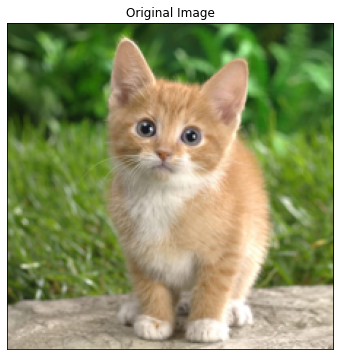

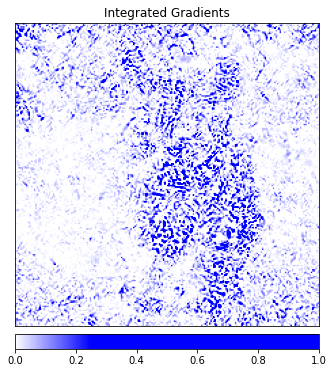

In [10]:
# show the original image for comparison
_ = viz.visualize_image_attr(None,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(),
                                          (1,2,0)),
                             method='original_image',
                             title='Original Image')

default_cmap = LinearSegmentedColormap.from_list('custom_blue',
                                                 [(0, '#ffffff'), (0.25, '#0000ff'), (1, '#0000ff')],
                                                 N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(),
                                          (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(),
                                          (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In the image above, we saw that Integrated Gradients gives us the strongest signal around the cat's location in the image.

#Feature Attribution with Occlusion
*Perturbation-based attribution* methods approach model understanding more directly, by introducing changes to the output to measure the effect on the output.

**Occlusion** involves replacing sections of the input image, and examining the effect on the output signal.

Similarly to configuring a CNN, we can specify the size of the target region, and a stride length to determine the spacing of individual measurements. We will visualize the output of our Occlusion attribution with `visualize_image_attr_multiple()`, showing heat maps of both positive and negative attribution by region, and by masking the original image with the positive attribution regions.

In [11]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3,8,8),
                                       sliding_window_shapes=(3,15,15),
                                       baselines=0)

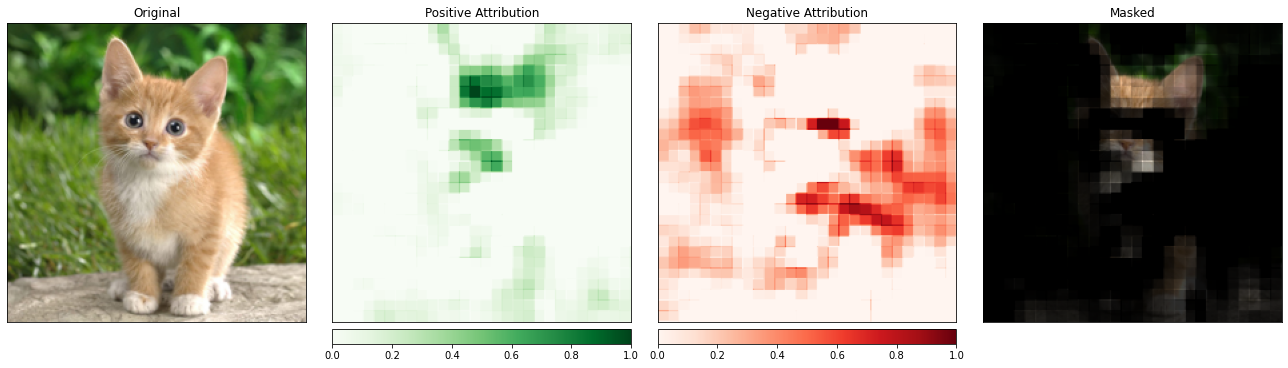

In [12]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(),
                                                   (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(),
                                                   (1,2,0)),
                                      ['original_image', 'heat_map', 'heat_map', 'masked_image'],
                                      ['all', 'positive', 'negative', 'positive'],
                                      show_colorbar=True,
                                      titles=['Original', 'Positive Attribution', 'Negative Attribution', 'Masked'],
                                      fig_size=(18,6))

#Layer Attribution with Layer GradCAM
**Layer Attribution** allows us to attribute teh activity of hidden layers within our model to feature of our input.

GradCAM computes the gradients of the target output with respect to the given layer, averages for each output channel (dimension 2 of output), and multiplies the average gradient for each channel by the layer activations. The results are summed over all channels. GradCAM is designed for CNNs; since the activity of conv layers often maps spatially to the input.

Layer attribution is set up similarly to input attribution, except that in addition to the model, we must  specify a hidden layer within the model that we wish to examine.

In [13]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img,
                                           target=pred_label_idx)

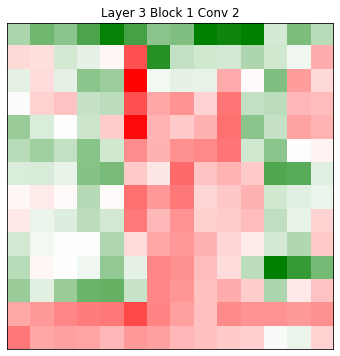

In [14]:
_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign='all',
                             title='Layer 3 Block 1 Conv 2')

We use the `interpolate()` method in the **LayerAttribution** base class to upsample this attribution data for comparison to the input image.

In [15]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc,
                                               input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


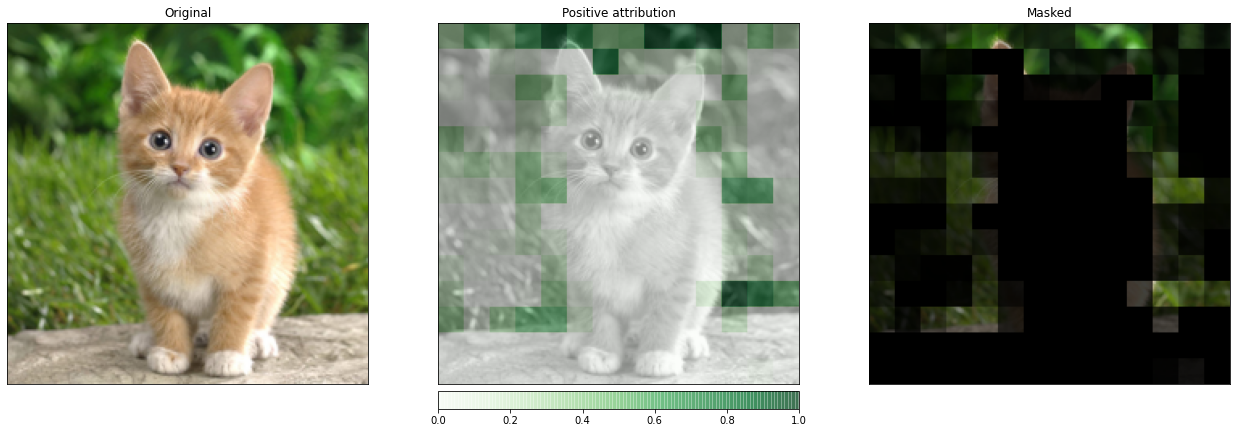

In [16]:
_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ['original_image', 'blended_heat_map', 'masked_image'],
                                      ['all', 'positive', 'positive'],
                                      show_colorbar=True,
                                      titles=['Original', 'Positive attribution', 'Masked'],
                                      fig_size=(18,6))

This visualizzation gives us novel insights into how our hidden layers respond to our input.

#Visualization with Captum Insights
Captum Insights allows us to visualize attribution for multiple input/output pairs, and provides visualization tools for image, text, and arbitrary data.

Here we will visualize multiple image classification inferences with Captum Insights.


First, we gather some images and see what the model thinks of them:

In [17]:
imgs = ['img/cat.jpg', 'img/teapot.jpg', 'img/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output,1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

    print('Predicted:', predicted_label, '/', pred_label_idx.item(),
          '(', prediction_score.squeeze().item(), ')')

Predicted: tabby / 281 ( 0.4236903488636017 )
Predicted: teapot / 849 ( 0.8184314370155334 )
Predicted: trilobite / 69 ( 0.9999834299087524 )


We use the Captum Insights widget, which we configure with an `AttributionVisualizer` object. The `AttributionVisualizer` expects batches of data, so we bring in Captum's `Batch` helper class. In addition, we look at images specifically, so we also need to import `ImageFeature`.

We configure the `AttributionVisualizer` with the following arguments:
* An array of models to be examined (in our case, just the one)
* A scoring function, which allows Captum Insights to pull out the top-k predictions from a model
* An ordered, human-readable list of classes our model is trained on
* A list of features to look for - in our case, an `ImageFeature`
* A dataset, which is an iterable object returning batches of inputs and labels - just like we used for training

In [21]:
%pip install flask_compress

     |████████████████████████████████| 357 kB 5.0 MB/s 


In [22]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

In [23]:
# Baseline is all-zeros input - this may differ depending on our data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i

In [24]:
input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

In [36]:
visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(0, 1),
    classes=list(map(lambda k: idx_to_labels[k][1],
                     idx_to_labels.keys())),
    features=[ImageFeature('Photo',
                           baseline_transforms=[baseline_func],
                           input_transforms=[])],
    dataset=[Batch(input_imgs, labels=[281, 849, 69])]

)

Running the cell below will render the Captum Insights widget.

In [37]:
from google.colab import output
output.enable_custom_widget_manager()

In [38]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()

In [33]:
output.disable_custom_widget_manager()